In [1]:
# imports
import matplotlib.pyplot as plt
import matplotlib
# import joblib
import cv2
import os
import torch 
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import time
import random
import math
import sys
sys.path.append('../')

#import pretrainedmodels
from imutils import paths
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from torchvision.transforms import transforms
from torch.utils.data import DataLoader, Dataset
from tqdm import tqdm

from gated import *
from resnet import resnet18
from resnet_gated import resnet18_gated
from train import train_sgd, test, train_gated
from dataset import *

[0.05, 0.04351133533380851, 0.03763019350290237, 0.03233860639039575, 0.027610188407766852, 0.023412708106044778, 0.019710173577058045, 0.01646450246756338, 0.013636839516207507, 0.011188577139226377, 0.00908212776868068, 0.0072814904000044894, 0.005752648131336976, 0.004463828361377955, 0.003385652732557608, 0.0024911998332304472, 0.0017560000734507363, 0.001157978988356383, 0.0006773624649329806, 0.00029655499559261365]


In [2]:
# !pip install pretrainedmodels

In [3]:
# device = torch.device("cpu")
device = torch.device("cuda")
dtype = torch.float
BATCH_SIZE = 64

In [4]:
image_paths = list(paths.list_images('../data/101_ObjectCategories'))
data = []
labels = []
for image_path in image_paths:
    label = image_path.split(os.path.sep)[-2]
    if label == 'BACKGROUND_Google':
        continue
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    data.append(image)
    labels.append(label)
data = np.array(data)
labels = np.array(labels)

/home/beomgon/anaconda3/envs/pytorch_retina/lib/python3.7/site-packages/ipykernel_launcher.py:12: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  if sys.path[0] == '':


In [5]:
len(set(labels))

101

In [6]:
# one hot encode
lb = LabelBinarizer()
labels = lb.fit_transform(labels)
print(f"Total number of classes: {len(lb.classes_)}")


Total number of classes: 101


In [7]:
# divide the data into train, validation, and test set
(x_train, x_val , y_train, y_val) = train_test_split(data, labels, 
                                                    test_size=0.3,  
                                                    stratify=labels,
                                                    random_state=42)

(x_val, x_test, y_val, y_test) = train_test_split(x_val, y_val, 
                                                    test_size=0.65, 
                                                    random_state=42)
print(f"x_train examples: {x_train.shape}\nx_test examples: {x_test.shape}\nx_val examples: {x_val.shape}")

x_train examples: (6073,)
x_test examples: (1693,)
x_val examples: (911,)


In [8]:
np.argmax(y_val[:20], axis=-1)

array([98,  3, 65, 52,  0,  1, 71, 72,  3,  3, 23,  3,  1, 55,  1, 11, 17,
       40, 90, 53])

In [9]:
train_data = ImageDataset(x_train, y_train, train_transform)
val_data = ImageDataset(x_val, y_val, val_transform)
test_data = ImageDataset(x_test, y_test, val_transform)

# dataloaders
trainloader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
valloader = DataLoader(val_data, batch_size=BATCH_SIZE, shuffle=True)
testloader = DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=False)

In [10]:
model = resnet18(pretrained=False).to(device)
model_gated = resnet18_gated(pretrained=False).to(device)

dilation [False, False, False]
stride 1
downsample
stride 2
downsample
stride 2
downsample
stride 2
dilation [False, False, False]
stride 1
downsample
stride 2
downsample
stride 2
downsample
stride 2


In [11]:
# optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.9, weight_decay=0) 

In [12]:
# # for i in optimizer.param_groups :
# #     print(i)
# (optimizer.param_groups[0].keys())

Training on 6073 examples, validating on 911 examples...
Epoch 1 of 20
Train Loss: 0.0599, Train Acc: 21.59
Val Loss: 0.0625, Val Acc: 23.71
Epoch 2 of 20
Train Loss: 0.0495, Train Acc: 30.59
Val Loss: 0.0537, Val Acc: 31.17
Epoch 3 of 20
Train Loss: 0.0427, Train Acc: 38.88
Val Loss: 0.0427, Val Acc: 41.93
Epoch 4 of 20
Train Loss: 0.0366, Train Acc: 45.18
Val Loss: 0.0368, Val Acc: 46.10
Epoch 5 of 20
Train Loss: 0.0308, Train Acc: 52.10
Val Loss: 0.0327, Val Acc: 51.26
Epoch 6 of 20
Train Loss: 0.0253, Train Acc: 59.03
Val Loss: 0.0285, Val Acc: 57.63
Epoch 7 of 20
Train Loss: 0.0205, Train Acc: 65.35
Val Loss: 0.0288, Val Acc: 58.07
Epoch 8 of 20
Train Loss: 0.0157, Train Acc: 73.54
Val Loss: 0.0250, Val Acc: 62.90
Epoch 9 of 20
Train Loss: 0.0111, Train Acc: 80.80
Val Loss: 0.0249, Val Acc: 63.45
Epoch 10 of 20
Train Loss: 0.0078, Train Acc: 86.09
Val Loss: 0.0247, Val Acc: 66.52
Epoch 11 of 20
Train Loss: 0.0028, Train Acc: 96.25
Val Loss: 0.0169, Val Acc: 75.52
Epoch 12 of 20
Tr

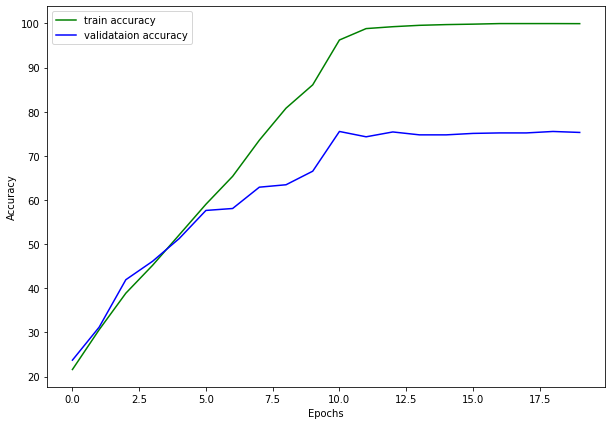

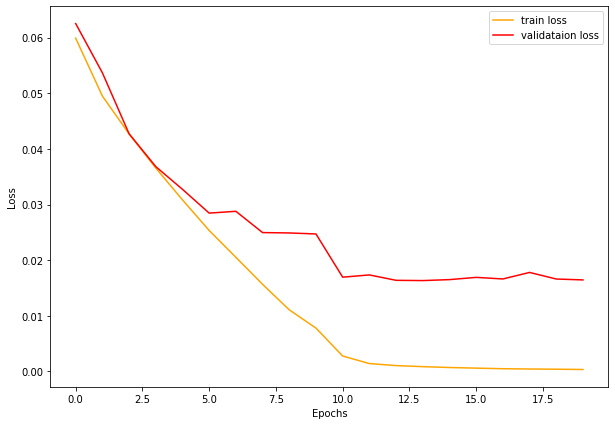

In [13]:
print(f"Training on {len(train_data)} examples, validating on {len(val_data)} examples...")
train_sgd(model, trainloader, valloader, decay=0)

In [14]:
correct, total = test(model, testloader)
print('Accuracy of testthe network on test images: %0.3f %%' % (100 * correct / total))
print('train.py finished running')

Accuracy of testthe network on test images: 74.424 %
train.py finished running


Training on 6073 examples, validating on 911 examples...
Epoch 1 of 20
Train Loss: 0.0571, Train Acc: 24.80
Val Loss: 0.0616, Val Acc: 25.25
Epoch 2 of 20
Train Loss: 0.0434, Train Acc: 39.35
Val Loss: 0.0429, Val Acc: 42.04
Epoch 3 of 20
Train Loss: 0.0362, Train Acc: 47.31
Val Loss: 0.0398, Val Acc: 47.75
Epoch 4 of 20
Train Loss: 0.0310, Train Acc: 54.29
Val Loss: 0.0371, Val Acc: 50.05
Epoch 5 of 20
Train Loss: 0.0271, Train Acc: 59.54
Val Loss: 0.0338, Val Acc: 52.03
Epoch 6 of 20
Train Loss: 0.0238, Train Acc: 64.61
Val Loss: 0.0288, Val Acc: 57.19
Epoch 7 of 20
Train Loss: 0.0208, Train Acc: 69.32
Val Loss: 0.0259, Val Acc: 61.03
Epoch 8 of 20
Train Loss: 0.0181, Train Acc: 74.02
Val Loss: 0.0262, Val Acc: 60.81
Epoch 9 of 20
Train Loss: 0.0158, Train Acc: 77.49
Val Loss: 0.0248, Val Acc: 64.22
Epoch 10 of 20
Train Loss: 0.0138, Train Acc: 81.43
Val Loss: 0.0250, Val Acc: 63.89
Epoch 11 of 20
Train Loss: 0.0120, Train Acc: 84.87
Val Loss: 0.0237, Val Acc: 65.53
Epoch 12 of 20
Tr

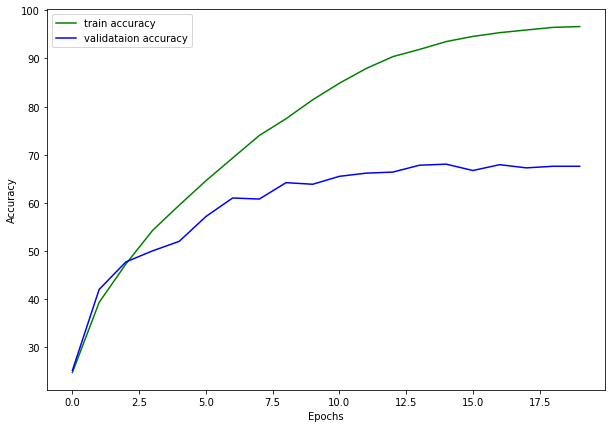

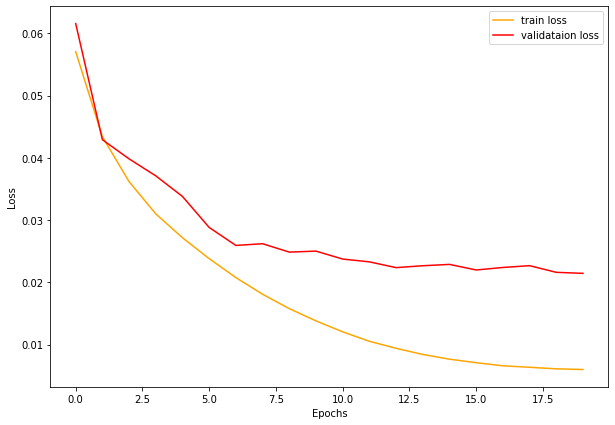

In [13]:
print(f"Training on {len(train_data)} examples, validating on {len(val_data)} examples...")
train_gated(model_gated, trainloader, valloader, decay=0)

In [14]:
correct, total = test(model_gated, testloader)
print('Accuracy of testthe network on test images: %0.3f %%' % (100 * correct / total))
print('train.py finished running')

Accuracy of testthe network on test images: 70.112 %
train.py finished running
